In [230]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import pandas as pd
import os
import quantecon as qe

'''
Read in the data.  
If readdata = 0 then read in the covariance matrix from a spreadsheet. 
If readdata = 1 then import the residuals from stata and compute the covariance matrix.

Note: It takes about 6 minutes to compute the covariance matrix.  I have not optimized the code yet (using numba).

'''
path = "//Users//kevinandrew//Desktop//Python"
os.chdir(path)

readdata = 0
if (readdata == 1):

    data = pd.read_excel("residuals.xlsx", index_col = None, header = None, names = ['id', 'yr', 'resid'])
    residuals = data.values

    times = residuals[:,1].astype(int)
    times = times - 1

    bigit = residuals.shape[0]
    namax = times.max()

    covmat = np.zeros([namax+1,namax+1])
    numvar = np.zeros([namax+1,namax+1])

    qe.util.tic()
    for it in range(bigit):
        if (it % 1000 == 0):
            print(it, 'Individuals processed')
        for it2 in range(bigit):
            if (residuals[it,0] == residuals[it2,0]):
                covmat[times[it], times[it2]] += residuals[it,2] * residuals[it2,2]
                numvar[times[it], times[it2]] += 1.
                
    qe.util.toc()
    covmat = covmat[0:14,0:14]    
    ## convert your array into a dataframe
    df = pd.DataFrame(covmat)

    ## save to xlsx file
    filepath = 'covmat.xlsx'
    df.to_excel(filepath, index=False)
    
    df2 = pd.DataFrame(numvar)
    filepath = 'indmat.xlsx'
    df2.to_excel(filepath, index = False)
    
    namax = covmat.shape[0]
else:
    df = pd.read_excel("covmat.xlsx", index_col = None)
    covmat = df.values
    df2 = pd.read_excel("indmat.xlsx", index_col = None)
    numvar = df2.values
    
    namax = covmat.shape[0]

'''
Make sure that I divide by the correct number of observations.
'''
for ia in range(namax):
    for ia2 in range(namax):
        covmat[ia,ia2] = covmat[ia,ia2] / numvar[ia,ia2]
'''
Count up the total number of observations in the sample.
'''        
numobs = 0.
for ia in range(namax):
    for ia2 in range(ia2,namax):
        numobs = numobs + numvar[ia,ia2]
        

As a first pass I inspect the covariance matrix to check that it's general shape is similar to guvenen's paper.  If you look at Figure 6 in Guvenen's paper it seems that the overall shape is simialar.

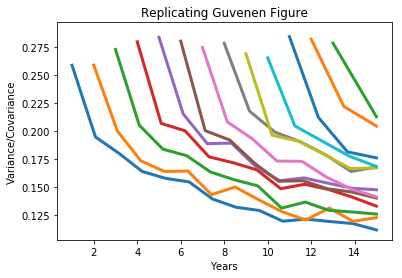

In [231]:
'''
Inspect the covariance matrix
'''

for ia in range(namax):
    agrid = np.linspace(ia+1,namax+1,namax-ia)
    aplot = covmat[ia,ia:namax]
    plt.plot(agrid, aplot, linewidth = 3)
plt.xlabel('Years')
plt.ylabel('Variance/Covariance')
plt.title('Replicating Guvenen Figure')
plt.show()


Now that I have the data inputted in panel form, with a unique id and a unique year identifier I can think seriously about constructing the covariane matrix.  There are two types of entries into the covariance matrix:

$$\mathbb{V}(y_{i,a}) = \frac{1}{\# I_a}\sum_{i\in\mathcal{I}} \mathbb{I}(y_{i,a}\neq 0) y_{i,a}^2  $$

Since the residuals are created to have a mean zero we just need to sum the squares of the residuals for all age $a$ firms and be careful to divide by the number in the sample.

$$\mathbb{COV}(y_{i,a},y_{i,a+n}) = \frac{1}{\# I_{a,n}} \sum_{i\in\mathcal{I}} \mathbb{I}(y_{i,a},y_{i,a+n}\neq 0) y_{i,a} y_{i,a+n}$$

Once again the fact that the means are 0 by design is handy.  The code needs to calculate the sums as well as the number of observations that contribute to the sum for each covariance and variance.  

The above code computes the covariance matrix.  What are the population moments for the following statistical model for these residuals?

The simplest version of Guvenen's model (RIP with constant variances) has population moments:

$$\mathbb{V}(y_{i,a}) = \sigma_\alpha^2 + \mathbb{V}(z_{i,a}) + \sigma_\varepsilon^2$$

$$\mathbb{COV}(y_{i,a},y_{i,a+n}) = \sigma_\alpha^2 + \rho^n \mathbb{V}(z_{i,a})$$

Where the variance of the AR(1) is defined recursively as:
$$\mathbb{V}(z_{i,a}) = \rho^2 \mathbb{V}(z_{i,a-1}) + \sigma_\eta^2$$
For new entrants to the panel:
$$\mathbb{V}(z_{i,a}) = \sigma^2_\eta $$

For the HIP implementation:
$$\mathbb{V}(y_{i,a}) = \sigma_\alpha^2 + 2\sigma_{\alpha\beta} a + \sigma^2_\beta a^2 + \mathbb{V}(z_{i,a}) + \sigma_\varepsilon^2$$

$$\mathbb{COV}(y_{i,a},y_{i,a+n}) = \sigma_\alpha^2 + \sigma_{\alpha\beta}(2a+n) + \sigma^2_\beta a (a+n) + \rho^n \mathbb{V}(z_{i,a})$$

The code below defines functions which retur the **distance** between the empirical covariances and the population moments defined above for a given set of parameters:
    $$\Theta_{RIP} = \{\rho, \sigma^2_\alpha, \sigma^2_\eta, \sigma^2_\varepsilon\} $$
       $$\Theta_{HIP} = \{\rho, \sigma^2_\alpha, \sigma^2_\beta, \sigma_{\alpha\beta}, \sigma^2_\eta, \sigma^2_\varepsilon\} $$
       
I equally weight each of the moments and calculate the square of the difference.  

In [232]:
#a vector of values
def guvenen_rip(xin,covmat):
    rho   = xin[0] 
    sig2a = xin[1]
    sig2e = xin[2] 
    sig2n = xin[3] 
    
    namax = covmat.shape[0]
    popmom = 0.
    for ia in range(namax):
        varz = sig2n
        for ia2 in range(ia):
            varz += rho ** 2. * varz + sig2n
        
        for ia2 in range(ia,namax):
            nn = ia2 - ia
            age = ia + 1
            freturn = 0.            

            if (nn == 0):
                popmom = sig2a + varz + sig2e
                freturn += (popmom - covmat[ia,ia2])** 2.
            else:
                popmom = sig2a + rho ** nn * varz
                freturn += (popmom - covmat[ia,ia2]) ** 2.
    return freturn


def guvenen_hip(xin,covmat):
    rho   = xin[0] 
    sig2a = xin[1]
    sig2b = xin[2]
    sigab = xin[3] 
    sig2n = xin[4] 
    sig2e = xin[5]

    
    namax = covmat.shape[0]
    popmom = 0.
    

    
    for ia in range(namax):
        varz = sig2n
        for ia2 in range(ia):
            varz += rho ** 2. * varz + sig2n
        for ia2 in range(ia,namax):
            nn = ia2 - ia
            age = ia + 1
            freturn = 0.

            if (nn == 0):
                popmom = sig2a + 2*sigab * age + sig2b * age ** 2. + varz + sig2e
                freturn += (popmom - covmat[ia,ia2])** 2.
            else:
                popmom = sig2a + sigab * (2 * age + nn) + sig2b * age * (age + nn) + rho ** nn * varz 
                freturn += (popmom - covmat[ia,ia2]) ** 2.
    return freturn




Now I turn to minimizing the objective to find the optimal parameters.  I find that the initial values matter a lot so my strategy is to draw initial values from a uniform distribution and solve the optimization problem many times.  I take the best solution as the correct one.  Even following this approach leads to some variability in the estimates.  I think this is due to the objective being jagged and the short panel leading to identification issues.

I supply some bounds as the routine likes to pick negative variances and $\rho >1$ otherwise.  In this implementation I optimize 1000 times.  In this example below I run the optimization 5 times and show how well I match the covariance matrix each time as well as the parameter values.

It is clear that the level of the covariances is being missed.  There is some tension between estimating $\rho$ and estimating $\sigma^2_\eta$.  Also, I think I need age dependent $\sigma^2_\varepsilon$ to match the levels.  The both impact the term $\mathbb{V}(z_{i,z})$ which is import for the level of the variances and covariances. 

I am also a little surprised the $\rho$ is not higher.  

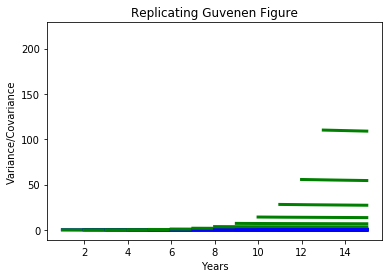

rho =  0.8760980123013318  sig2a =  0.021172486725211423
sig2e =  0.0682378484906269  sig2n =  0.0015516424170056462


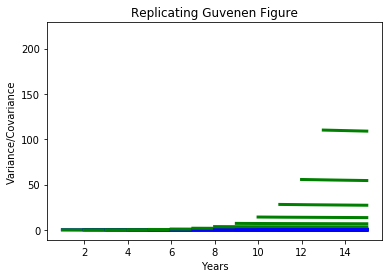

rho =  0.8701123856772908  sig2a =  0.09291888272091522
sig2e =  0.06432242930614746  sig2n =  0.006200709638953523


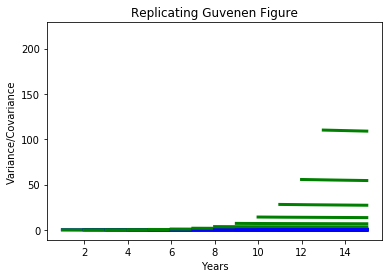

rho =  0.8905863064217371  sig2a =  0.01629033762265882
sig2e =  0.04681075341074862  sig2n =  0.00015667920553867


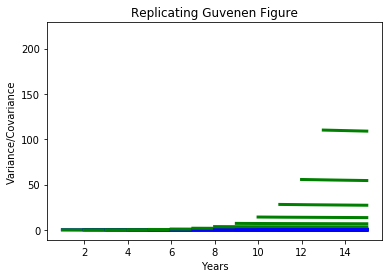

rho =  0.7344513700714654  sig2a =  0.07780699082706563
sig2e =  0.03085419024102648  sig2n =  0.002036161619562457


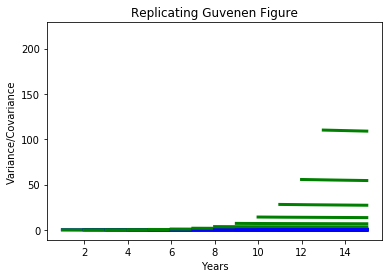

rho =  0.7573597442677568  sig2a =  0.0016846812701981253
sig2e =  0.09208683892040283  sig2n =  0.003759517592465563


In [233]:
#minimize the guvenen rip process print the optimal parameters and show how it matches the cov. matrix
#bounds = ([7, .9999], [0., .5], [0., .1], [0., .1], [0., .1], [0., .1], [0., .1], [0., .1], [0., .1], [0., .1], [0., .1], [0., .1], [0., .1],  [0., .1], [0., .1], [0., .1], [0., .1])

bounds = ([7, .9999], [0., .1], [0., .1], [0., .1])
nparam = 4
x0 = np.zeros(nparam)
nsim = 10
xstore = np.zeros([nsim,nparam])
xmin = np.zeros(nsim)
for icheck in range(5):
    for imin in range(nsim):
        x0[0] = np.random.uniform(.7,.9999)
        x0[1] = np.random.uniform(.00001, .1)
        x0[2] = np.random.uniform(.00001, .1)
        x0[3] = np.random.uniform(.00001, .1)
        
        xopt = minimize(guvenen_rip, x0, method = 'TNC', args = (covmat), bounds = bounds)
        #xopt = minimize(guvenen_rip, x0, method = 'TNC', args = (covmat))
        xstore[imin-1,:] = xopt.x
        xmin[imin-1] = xopt.fun
    xstar = xstore[xmin.argmin(),:]

    rho   = xstar[0] 
    sig2a = xstar[1]
    sig2e = xstar[2] 
    sig2n = xstar[3] 
    rho =  0.99
    sig2a = .05
    sig2n = .015
    sig2e = .06
    #calculate the population moments to see how we did
    namax = covmat.shape[0]
    popmat = np.zeros([namax,namax])
    newcovmat = np.zeros([namax,namax])


    for ia in range(namax):
        varz = sig2n
        for ia2 in range(ia):
            varz += rho ** 2. * varz + sig2n

        for ia2 in range(ia,namax):
            nn = ia2 - ia
            age = ia + 1


            if (nn == 0):
                popmat[ia,ia2] = sig2a + varz + sig2e
            else:
                popmat[ia,ia2] = sig2a + rho ** nn * varz

    for ia in range(namax):
        for ia2 in range(ia2,namax):
            newcovmat[ia,ia2] = covmat[ia,ia2] / numvar[ia,ia2]


    for ia in range(namax):
        agrid = np.linspace(ia+1,namax+1,namax-ia)
        aplot = covmat[ia,ia:namax]
        pplot = popmat[ia,ia:namax]
        plt.plot(agrid, aplot, 'b-', linewidth = 3)
        plt.plot(agrid, pplot, 'g-', linewidth = 3)

        plt.xlabel('Years')
    plt.ylabel('Variance/Covariance')
    plt.title('Replicating Guvenen Figure')
    plt.show() 

    print('rho = ',xstar[0], ' sig2a = ', xstar[1])
    print('sig2e = ',xstar[2], ' sig2n = ', xstar[3])

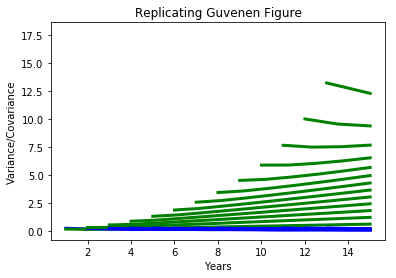

rho =  0.7559008172127573  sig2a =  0.08122754253512754
sig2b =  0.043361373225706795  sigab =  -0.003912972735312603
sig2n =  0.009437764784251587  sig2e =  0.03273205504926968


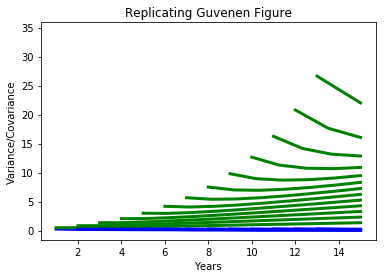

rho =  0.6224531466010262  sig2a =  0.27542839447114165
sig2b =  0.06880941252048274  sigab =  0.007578000811387731
sig2n =  0.08051667982027316  sig2e =  0.05567438395768087


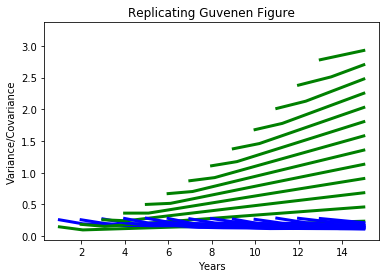

rho =  0.6524053221108586  sig2a =  0.08061469775275855
sig2b =  0.01636269070658128  sigab =  -0.00489700852959875
sig2n =  1.6766046129196574e-05  sig2e =  0.04225314854364675


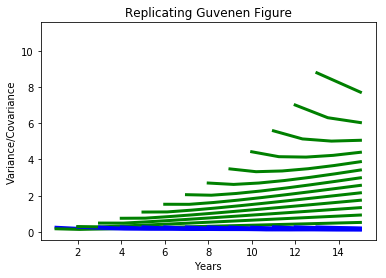

rho =  0.6239045862067909  sig2a =  0.056401265062040684
sig2b =  0.0288096350555331  sigab =  0.0043881160830500105
sig2n =  0.020254160253949424  sig2e =  0.09274984052631952


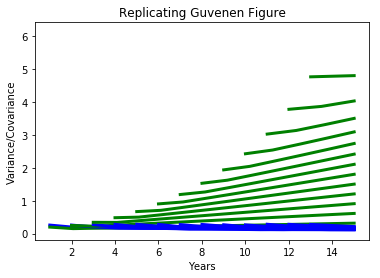

rho =  0.8399587325631461  sig2a =  0.1304662839059562
sig2b =  0.021710433463558887  sigab =  -0.007830381507401268
sig2n =  0.0007604230300872449  sig2e =  0.08615109879452598


In [234]:

#do some fancy minimizing
nsim = 10
nparam = 6
xstore = np.zeros([nsim,nparam])
xmin = np.zeros(nsim)
x0 = np.zeros(nparam)
bounds = ([6, .9999], [0., .3], [0., .1],[-.01,.01] ,[0., .1],[0., .1])

for icheck in range(5):
    for imin in range(nsim):
        x0[0] = np.random.uniform(.6,.9999)
        x0[1] = np.random.uniform(.00001, .3)
        x0[2] = np.random.uniform(.00001, .1)
        x0[3] = np.random.uniform(-.01, .01)
        x0[4] = np.random.uniform(.00001, .1)
        x0[5] = np.random.uniform(.0, 0.1)
        xopt = minimize(guvenen_hip, x0, method = 'TNC', args = (covmat),bounds=bounds)
        xstore[imin-1,:] = xopt.x
        xmin[imin-1] = xopt.fun
    xstar = xstore[xmin.argmin(),:]


    rho   = xstar[0] 
    sig2a = xstar[1]
    sig2b = xstar[2] 
    sigab = xstar[3] 
    sig2n = xstar[4] 
    sige = xstar[5]

    namax = covmat.shape[0]
    popmat = np.zeros([namax,namax])

    for ia in range(namax):
        varz = sig2n
        for ia2 in range(ia):
            varz += rho ** 2. * varz + sig2n
        for ia2 in range(ia,namax):
            nn = ia2 - ia
            age = ia + 1        

            if (nn == 0):
                popmat[ia,ia2] = sig2a + 2 * sigab * age + sig2b * age ** 2. + varz + sig2e

            else:
                popmat[ia,ia2] = sig2a + sigab * (2 * age + nn) + sig2b * age * (age + nn) + rho ** nn * varz 


    for ia in range(namax):
        agrid = np.linspace(ia+1,namax+1,namax-ia)
        aplot = covmat[ia,ia:namax]
        pplot = popmat[ia,ia:namax]
        plt.plot(agrid, aplot, 'b-', linewidth = 3)
        plt.plot(agrid, pplot, 'g-', linewidth = 3)

        plt.xlabel('Years')
    plt.ylabel('Variance/Covariance')
    plt.title('Replicating Guvenen Figure')
    plt.show() 

    print('rho = ',xstar[0], ' sig2a = ', xstar[1])
    print('sig2b = ',xstar[2], ' sigab = ', xstar[3])
    print('sig2n = ',xstar[4], ' sig2e = ', xstar[5])